## Election Returns by Precinct Dataset

From the [Illinois State Board of Elections](https://www.elections.il.gov/electionoperations/ElectionVoteTotalsPrecinct.aspx?ID=bt7bri46n7I%3d), we obtain voting results by precinct for the 2016 Presidential Election. 

In [137]:
import pandas as pd

In [312]:
df = pd.read_csv('51-120-PRESIDENT AND VICE PRESIDENT-2016GE.csv')

In [314]:
df.head()

,JurisdictionID,JurisContainerID,JurisName,EISCandidateID,CandidateName,EISContestID,ContestName,PrecinctName,Registration,EISPartyID,PartyName,VoteCount
0,87,0,STARK,150,DONALD J. TRUMP,120,PRESIDENT AND VICE PRESIDENT,GOSHEN,516,12,REPUBLICAN,237
1,87,0,STARK,150,DONALD J. TRUMP,120,PRESIDENT AND VICE PRESIDENT,VALLEY,196,12,REPUBLICAN,111
2,54,0,LOGAN,5010,JILL STEIN,120,PRESIDENT AND VICE PRESIDENT,EAST LINCOLN 5,1158,13,GREEN,8
3,54,0,LOGAN,5010,JILL STEIN,120,PRESIDENT AND VICE PRESIDENT,WEST LINCOLN 2,512,13,GREEN,4
4,54,0,LOGAN,5015,GARY JOHNSON,120,PRESIDENT AND VICE PRESIDENT,AETNA,346,19,LIBERTARIAN,10


The only features we care about are ```JurisName,PrecinctName,Registration,VoteCount```, so let's start cleaning. 


In [316]:
# We only care about the city of chicago
filtered_df = df[df['JurisName']=='CITY OF CHICAGO']

# After filtering, no longer need this feature
filtered_df = filtered_df.drop('JurisName', axis=1)

# Group the 'VoteCount' by 'PrecinctName' and calculate the sum (TotalVotesPerPrecinct) for each precinct
grouped_df = filtered_df.groupby('PrecinctName')['VoteCount'].sum().reset_index()

# Rename the column to 'TotalVotesPerPrecinct'
grouped_df.rename(columns={'VoteCount': 'votes'}, inplace=True)

# Add the 'Registration' column to the grouped DataFrame
grouped_df = pd.merge(grouped_df, filtered_df[['PrecinctName', 'Registration']].drop_duplicates(), on='PrecinctName', how='left')

# Compute Voter Turnout Percentage 
grouped_df['VoterTurnoutPercentage'] = (grouped_df['votes']/grouped_df['Registration']).round(4)

# Split 'PrecinctName' into 'Ward' and 'Precinct'features, to better match shape files
grouped_df[['Ward', 'Precinct']] = grouped_df['PrecinctName'].str.extract(r'Ward (\d+) Precinct (\d+)')

# Convert the Ward and Precinct values into ints
grouped_df[['Ward', 'Precinct']] = grouped_df[['Ward', 'Precinct']].astype(int)

# No longer need the 'PrecinctName' feature after the splitting
grouped_df.drop('PrecinctName',axis=1)

,votes,Registration,VoterTurnoutPercentage,Ward,Precinct
0,632,894,0.7069,1,1
1,596,837,0.7121,1,2
2,741,1001,0.7403,1,3
3,714,921,0.7752,1,4
4,711,939,0.7572,1,5
...,...,...,...,...,...
2064,480,733,0.6548,50,36
2065,531,687,0.7729,50,37
2066,221,277,0.7978,50,38
2067,419,659,0.6358,50,39


## Visualizing Chicago Voter Turnout by Precinct

From Chase's previous searching, we'll use [this map](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Ward-Precincts-2012-2022-/uvpq-qeeq) of Chicago's voting precincts for 2012-2022.

In [169]:
from shapely import MultiPolygon, Polygon, wkt, intersection
import geopandas as gpd
import matplotlib.pyplot as plt 

In [171]:
precs = pd.read_csv('ChicagoPrecincts2012_2022.csv')

In [173]:
precs['the_geom'] = precs['the_geom'].apply(wkt.loads) 
precs = precs.rename(columns={'the_geom':'geometry','WARD':'Ward','PRECINCT':'Precinct'})
precs[['Ward', 'Precinct']] = precs[['Ward', 'Precinct']].astype(int)
precs = gpd.GeoDataFrame(precs, crs='epsg:4326')

In [151]:
precs.head()

,geometry,Ward,Precinct,FULL_TEXT,SHAPE_AREA,SHAPE_LEN
0,"MULTIPOLYGON (((-87.72263 41.97442, -87.72265 ...",39,12,39012,2.402920e+06,8750.363602
1,"MULTIPOLYGON (((-87.72843 41.98283, -87.72841 ...",39,39,39039,8.055746e+06,12090.673021
2,"MULTIPOLYGON (((-87.69304 41.98188, -87.69301 ...",40,1,40001,1.756462e+06,6868.846768
3,"MULTIPOLYGON (((-87.69569 41.9886, -87.69568 4...",40,2,40002,1.999752e+06,7439.578462
4,"MULTIPOLYGON (((-87.69203 41.97404, -87.69242 ...",40,5,40005,1.999124e+06,7366.565255


In [175]:
# Merge the 'VoterTurnoutPercentage' data obtained above with the Precinct Map
merged_df = pd.merge(precs, grouped_df[['Ward', 'Precinct', 'VoterTurnoutPercentage']], on=['Ward', 'Precinct'], how='left')

In [155]:
merged_df.head()

,geometry,Ward,Precinct,FULL_TEXT,SHAPE_AREA,SHAPE_LEN,VoterTurnoutPercentage
0,"MULTIPOLYGON (((-87.72263 41.97442, -87.72265 ...",39,12,39012,2.402920e+06,8750.363602,68.42
1,"MULTIPOLYGON (((-87.72843 41.98283, -87.72841 ...",39,39,39039,8.055746e+06,12090.673021,74.83
2,"MULTIPOLYGON (((-87.69304 41.98188, -87.69301 ...",40,1,40001,1.756462e+06,6868.846768,68.44
3,"MULTIPOLYGON (((-87.69569 41.9886, -87.69568 4...",40,2,40002,1.999752e+06,7439.578462,72.99
4,"MULTIPOLYGON (((-87.69203 41.97404, -87.69242 ...",40,5,40005,1.999124e+06,7366.565255,73.21


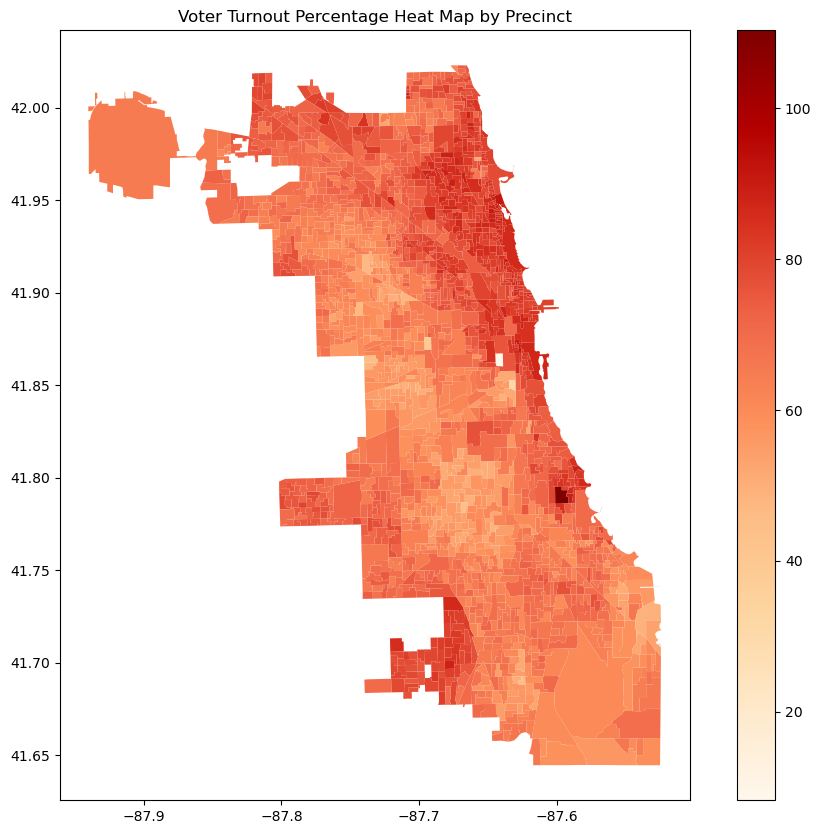

In [132]:
# Convert the DataFrame to a GeoDataFrame (assuming 'the_geom' contains WKT geometries)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Plot the GeoDataFrame with 'VoterTurnoutPercentage' as a heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged_gdf.plot(column='VoterTurnoutPercentage', ax=ax, legend=True, cmap='OrRd')


plt.title('Voter Turnout Percentage Heat Map by Precinct')

#plt.savefig('voter_turnout_heatmap.png', dpi=300)

plt.show()

In [181]:
merged_df['VoterTurnoutPercentage'].describe()

count    2069.000000
mean        0.698392
std         0.096165
min         0.082700
25%         0.628200
50%         0.694300
75%         0.774300
max         1.103200
Name: VoterTurnoutPercentage, dtype: float64

In [183]:
merged_df.loc[merged_df['VoterTurnoutPercentage'].idxmax()]

geometry                  MULTIPOLYGON (((-87.5924500005329 41.793316999...
Ward                                                                      5
Precinct                                                                 27
FULL_TEXT                                                              5027
SHAPE_AREA                                                    7427976.28201
SHAPE_LEN                                                      12315.492857
VoterTurnoutPercentage                                               1.1032
Name: 311, dtype: object

In [185]:
merged_df.loc[merged_df['VoterTurnoutPercentage'].idxmin()]

geometry                  MULTIPOLYGON (((-87.63901999949631 41.86022899...
Ward                                                                     11
Precinct                                                                  2
FULL_TEXT                                                             11002
SHAPE_AREA                                                     3698186.8078
SHAPE_LEN                                                       8048.842975
VoterTurnoutPercentage                                               0.0827
Name: 511, dtype: object

## Double-Checking Anomalous Voter Turnout

Two precincts were stark outliers in the data--Ward 11 Precinct 2 (at 8\% turnout) and Ward 5 Precinct 27 (at 110\% tunrout). We want to verify the vote counts from another source, from the [MIT Election Data & Science Lab](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/LYWX3D/C5CS03&version=11.1&toolType=PREVIEW). This is a very large dataset (~500 MB), as it contains election returns by precinct for the entire United States for the 2016 Presidential Election. 

In [318]:
# Set low_memory = False so Jupyter doesn't complain 
# (This tells pandas not to infer data types in chunks, which can cause inconsistencies in large files)
df1 = pd.read_csv('presidential_precincts_2016.csv', encoding='ISO-8859-1', low_memory=False)

In [320]:
features = ['state','jurisdiction','candidate_normalized','precinct','votes'] 
df1 = df1[features]
chc_df = df1[(df1['state']=='Illinois') & (df1['jurisdiction']=='COOK')] 
# Cook county comprises the city of Chicago and suburban Cook county 
# Chicago's precincts are all of the form 'Ward #1 Precinct #2', so we filter by those entries starting with 'W'
chc_df = chc_df[chc_df['precinct'].str.startswith('W')] 

In [322]:
chc_df = chc_df.groupby('precinct')['votes'].sum().reset_index()

In [324]:
chc_df[['Ward', 'Precinct']] = chc_df['precinct'].str.extract(r'Ward (\d+) Precinct (\d+)')
chc_df[['Ward', 'Precinct']] = chc_df[['Ward', 'Precinct']].astype(int)

In [326]:
chc_df = chc_df.drop('precinct',axis=1)

In [328]:
chc_df.head()

,votes,Ward,Precinct
0,632,1,1
1,596,1,2
2,741,1,3
3,714,1,4
4,711,1,5


In [330]:
# Retrieve vote count given df and Ward+Precinct values

def lookup_votes(df,ward_value, precinct_value):
    result = df[(df['Ward'] == ward_value) & (df['Precinct'] == precinct_value)]['votes']
    
    # Ensure there is exactly one match and return the value
    if not result.empty:
        return result.values[0]  # Retrieve the first (and only) value
    else:
        return "No match found"


In [293]:
lookup_votes(chc_df,11,2)

86

In [295]:
lookup_votes(chc_df,5,27)

866

In [332]:
# Search through both dataframes and return any values of Ward & Precinct with mismatched vote counts

def find_vote_mismatches(df1, df2):
    mismatches = []

    for index, row in df1.iterrows():
        ward_value = row['Ward']
        precinct_value = row['Precinct']
        votes1 = row['votes']

        # Use lookup_votes to get votes from df2
        votes2 = lookup_votes(df2, ward_value, precinct_value)

        # Compare votes and record mismatches
        if votes1 != votes2:
            mismatches.append((ward_value, precinct_value, votes1, votes2))
    
    return mismatches

mismatched_votes = find_vote_mismatches(grouped_df, chc_df)

In [334]:
print(mismatched_votes)

[]


The vote counts are verified! 